# Interactive Demonstration of Neural Network for Classification, 
Starting from Logistic Regression as a simple network!

In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, AppLayout
from ipywidgets import widgets
from copy import deepcopy

%matplotlib widget
plt.style.use('ggplot')
np.set_printoptions(legacy='1.25', precision=4)

# Synthetic Data - Classification

Let's work in 2D. Feature vector: $(x_1, x_2)\in \mathbb{R}^2$.

Label is binary: $y \in \{0,1\}$.



### Linear boundary

Let's start with a simple linear boundary for the labels. Use the sliders to set the boundary.


In [4]:
a1 = FloatSlider( value = 0.5, min = -1.0, max = 1.0, step = 0.1, description = 'a1')
a2 = FloatSlider( value = 1.0, min = 0.05, max = 4.0, step = 0.1, description = 'a2')
const = FloatSlider( value = 0.75, min = -3.0, max = 3.0, step = 0.1, description = 'const')

a1.layout.width = '50%'
a2.layout.width = '50%'
const.layout.width = '50%'

# Plot the boundary a1 x1 + a2 x2 = const
# Color the region a1 x1 + a2 x2 > const as blue, and the values a1 x1 + a2 x2 < const as red.
def plot_boundary(a1, a2, const):
    x1 = np.linspace(-5, 5, 100)
    x2 = -a1/a2 * x1 + const/a2
    with plt.ioff():
        fig = plt.figure()
        fig.canvas.toolbar_visible = False
        fig.canvas.header_visible = False
    line = plt.plot(x1, x2, "-", lw=2.0)
    plt.title(f'Boundary: {a1:.2f} x1 + {a2:.2f} x2 = {const:.2f}')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.axhline(0, color='black', lw=0.5)
    plt.axvline(0, color='black', lw=0.5)
    plt.grid(True)
    return line

line = plot_boundary(a1.value, a2.value, const.value)

def update_a1(change):
    line[0].set_ydata(-change['new']/a2.value * np.linspace(-5, 5, 100) + const.value/a2.value)
    plt.title(f'Boundary: {change["new"]:.2f} x1 + {a2.value:.2f} x2 = {const.value:.2f}')
    fig = plt.gcf()
    fig.canvas.draw()
    fig.canvas.flush_events()
    
def update_a2(change):
    line[0].set_ydata(-a1.value/change['new'] * np.linspace(-5, 5, 100) + const.value/change['new'])
    plt.title(f'Boundary: {a1.value:.2f} x1 + {change["new"]:.2f} x2 = {const.value:.2f}')
    fig = plt.gcf()
    fig.canvas.draw()
    fig.canvas.flush_events()

def update_const(change):
    line[0].set_ydata(-a1.value/a2.value * np.linspace(-5, 5, 100) + change['new']/a2.value)
    plt.title(f'Boundary: {a1.value:.2f} x1 + {a2.value:.2f} x2 = {change["new"]:.2f}')
    fig = plt.gcf()
    fig.canvas.draw()
    fig.canvas.flush_events()

app = AppLayout(
    header=None,
    left_sidebar=None,
    center=plt.gcf().canvas,
    pane_height = [1, 6, 1],
    footer = widgets.VBox([a1, a2, const])
)

a1.observe(update_a1, names='value')
a2.observe(update_a2, names='value')
const.observe(update_const, names='value')

display(app)

AppLayout(children=(VBox(children=(FloatSlider(value=0.5, description='a1', layout=Layout(width='50%'), max=1.…

In [5]:
# Store global variables for the true values of a1 and a2
a1_true = a1.value
a2_true = a2.value
const_true = const.value

def update_a1_true(change):
    global a1_true
    a1_true = change['new']
    
def update_a2_true(change):
    global a2_true
    a2_true = change['new']
    
def update_const_true(change):
    global const_true
    const_true = change['new']

a1.observe(update_a1_true, names='value')
a2.observe(update_a2_true, names='value')
const.observe(update_const_true, names='value')

## Synthetic samples on the plane
Let's assume we have noiseless data, that is, the boundary perfectly labels between the two labels of $y\in\{0,1\}$.

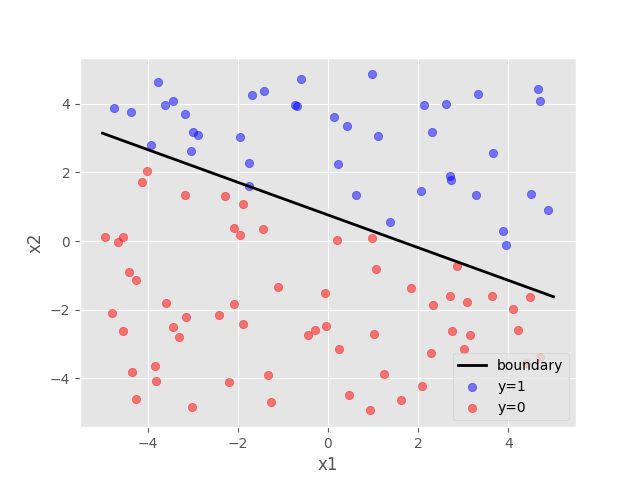

In [6]:
num_samples = 100
# Interactive scatter plot:
with plt.ioff():
    fig = plt.figure()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
np.random.seed(42)  # For reproducibility
x1s = np.random.uniform(-5, 5, num_samples)
x2s = np.random.uniform(-5, 5, num_samples)
y_true = np.where(a1_true * x1s + a2_true * x2s > const_true, 1, 0)
positive_x1s = x1s[y_true == 1]
positive_x2s = x2s[y_true == 1]
negative_x1s = x1s[y_true == 0]
negative_x2s = x2s[y_true == 0]
ax = plt.gca()
ax.plot(np.linspace(-5, 5, 100), -a1_true/a2_true * np.linspace(-5, 5, 100) + const_true/a2_true, color='black', lw=2.0, label='boundary')
ax.scatter(positive_x1s, positive_x2s, color='blue', label='y=1', alpha=0.5)
ax.scatter(negative_x1s, negative_x2s, color='red', label='y=0', alpha=0.5)
ax.legend()
ax.set_xlabel('x1')
ax.set_ylabel('x2')
display(fig.canvas)

## Logistic Regression as a network

The logistic regression models a probability distribution on $y$,

$$ h( y | x_1, x_2 ) = \dfrac{1}{1 + \exp(- w_1 x_1 - w_2 x_2 + b)} $$

Because the model exactly matches how we generated the synthetic data, the $w_1, w_2$, and $b$ parameters should directly correspond to the true values $a_1, a_2$ and $const$ (as we will see).

We can represent a logistic regression model as a network with two inputs and a bias (additive constant).



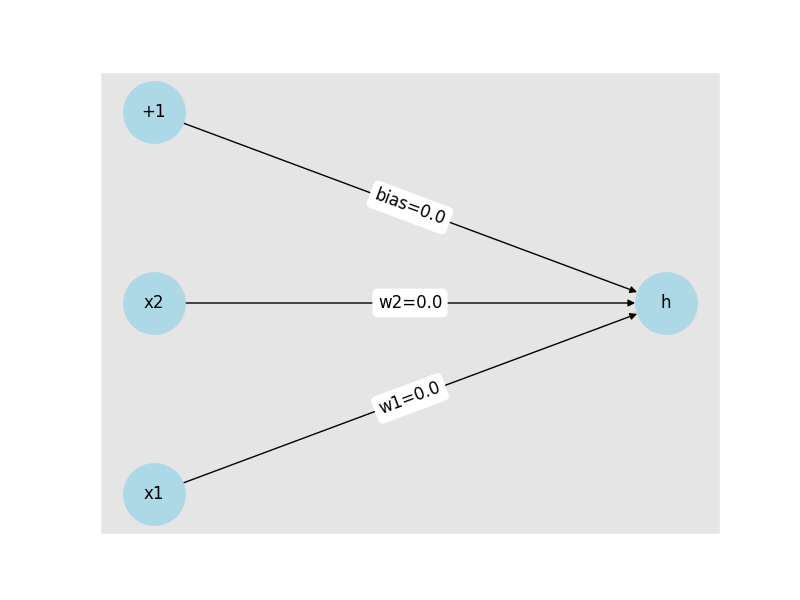

In [7]:
w1 = widgets.BoundedFloatText(
    value=0.0,
    min=-5,
    max=5,
    step=0.01,
    description='w1'
    )

w2 = widgets.BoundedFloatText(
    value=0.0,
    min=-5,
    max=5,
    step=0.01,
    description='w2'
    )

b = widgets.BoundedFloatText(
    value=0.0,
    min=-5,
    max=5,
    step=0.01,
    description='const'
    )

net = nx.DiGraph()
net.add_node('x1', pos=(0, 50), label='x1')
net.add_node('x2', pos=(0, 200), label='x2')
net.add_node('bias', pos=(0, 350), label='+1')
net.add_node('h', pos=(200, 200), label='h')
net.add_edges_from(
    [('x1', 'h', {'title': f"w1={w1.value}"}), ('x2', 'h', {'title': f"w2={w2.value}"}), ('bias', 'h', {'title': f"bias={b.value}"})]
)
fig = plt.figure(figsize=(8, 6))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
plt.grid(False)
nx.draw_networkx(net,
                 pos=nx.get_node_attributes(net, 'pos'), 
                 with_labels=False,
                 node_size=2000, 
                 node_color='lightblue', 
                 font_size=10, 
                 font_color='black', 
                 arrows=True)
nx.draw_networkx_labels(net, pos=nx.get_node_attributes(net, 'pos'),
                        labels=nx.get_node_attributes(net, 'label'),
                        font_size=12, 
                        font_color='black')
nx.draw_networkx_edge_labels(net, pos=nx.get_node_attributes(net, 'pos'),
                                edge_labels=nx.get_edge_attributes(net, 'title'),
                                font_size=12,
                                font_color='black')
plt.show()

## Try some values!

<span style="color:red">Exercise</span>: calculate the output for $h$ yourself to check if it's correct

In [8]:
x1_slider = widgets.FloatSlider(
    value=0.0,
    min=-5.0,
    max=5.0,
    step=0.1,
    description='x1'
)

x2_slider = widgets.FloatSlider(
    value=0.0,
    min=-5.0,
    max=5.0,
    step=0.1,
    description='x2'
)

w1_slider = widgets.FloatSlider(
    value=0.1,
    min=-5.0,
    max=5.0,
    step=0.1,
    description='w1'
)

w2_slider = widgets.FloatSlider(
    value=0.1,
    min=-5.0,
    max=5.0,
    step=0.1,
    description='w2'
)

bias_slider = widgets.FloatSlider(
    value=0.0,
    min=-5.0,
    max=5.0,
    step=0.1,
    description='bias'
)

sliders = widgets.HBox( [ widgets.VBox([x1_slider, x2_slider]), widgets.VBox([w1_slider, w2_slider, bias_slider]) ] )
_x1 = x1_slider.value
_x2 = x2_slider.value
_w1 = w1_slider.value
_w2 = w2_slider.value
_b = bias_slider.value

with plt.ioff():
    fig = plt.figure()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    ax = plt.gca()

def update_network():
    net = nx.DiGraph()
    ax.clear()
    global _x1
    global _x2
    global _w1
    global _w2
    global _b
    h = 1 / ( 1 + np.exp( - _w1 * _x1 - _w2 * _x2 + _b ) )
    net.add_node('x1', pos=(0, 50), label=f'{_x1:.2f}')
    net.add_node('x2', pos=(0, 200), label=f'{_x2:.2f}')
    net.add_node('bias', pos=(0, 350), label='+1')
    net.add_node('h', pos=(200, 200), label=f'{h:.2f}')
    net.add_edges_from(
        [('x1', 'h', {'title': f"w1={_w1:.2f}"}), ('x2', 'h', {'title': f"w2={_w2:.2f}"}), ('bias', 'h', {'title': f"bias={_b:.2f}"})]
    )
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    plt.grid(False)
    nx.draw_networkx(net,
                    pos=nx.get_node_attributes(net, 'pos'), 
                    with_labels=False,
                    node_size=2000, 
                    node_color='lightblue', 
                    font_size=10, 
                    font_color='black', 
                    arrows=True,
                    ax=ax)
    nx.draw_networkx_labels(net, pos=nx.get_node_attributes(net, 'pos'),
                            labels=nx.get_node_attributes(net, 'label'),
                            font_size=12, 
                            font_color='black',
                            ax=ax)
    nx.draw_networkx_edge_labels(net, pos=nx.get_node_attributes(net, 'pos'),
                                    edge_labels=nx.get_edge_attributes(net, 'title'),
                                    font_size=12,
                                    font_color='black',
                                    ax=ax)
    
update_network()

def update_x1(change):
    global _x1
    _x1 = change['new']
    update_network()

def update_x2(change):
    global _x2
    _x2 = change['new']
    update_network()
    
def update_w1(change):
    global _w1
    _w1 = change['new']
    update_network()

def update_w2(change):
    global _w2
    _w2 = change['new']
    update_network()
    
def update_bias(change):
    global _b
    _b = change['new']
    update_network()
    
x1_slider.observe(update_x1, names='value')
x2_slider.observe(update_x2, names='value')
w1_slider.observe(update_w1, names='value')
w2_slider.observe(update_w2, names='value')
bias_slider.observe(update_bias, names='value')

app = AppLayout(
    header=None,
    left_sidebar=None,
    center=fig.canvas,
    pane_height = [1, 6, 1],
    footer=sliders
)

display(app)

AppLayout(children=(HBox(children=(VBox(children=(FloatSlider(value=0.0, description='x1', max=5.0, min=-5.0),…

## Model Decision Boundary

For a given set of parameters $w_1, w_2$, and $bias$ we can also plot its boundary if we use the decision threshold $h(y|x_1,x_2) = 0.5$ (that is, if $h > 0.5$, we classify as label $y=1$ else if $h < 0.5$, label $y=0$).

In [9]:
w1_slider = widgets.FloatSlider(
    value=0.0,
    min=-5.0,
    max=5.0,
    step=0.1,
    description='w1'
)

w2_slider = widgets.FloatSlider(
    value=0.0,
    min=-5.0,
    max=5.0,
    step=0.1,
    description='w2'
)

bias_slider = widgets.FloatSlider(
    value=0.0,
    min=-5.0,
    max=5.0,
    step=0.1,
    description='bias'
)

sliders = widgets.VBox([w1_slider, w2_slider, bias_slider])

with plt.ioff():
    fig = plt.figure()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    ax = plt.gca()
    
def model_boundary():
    if _w2 != 0:
        x1 = np.linspace(-5, 5, 100)
        x2 = -_w1/_w2 * x1 + _b/_w2
    else:
        x2 = np.linspace(-5, 5, 100)
        x1 = -_w2/_w1 * x2 + _b/_w1
    ax.clear()
    ax.scatter(positive_x1s, positive_x2s, color='blue', label='y=1', alpha=0.5)
    ax.scatter(negative_x1s, negative_x2s, color='red', label='y=0', alpha=0.5)
    ax.legend()
    ax.plot(x1, x2, color='black', lw=2.0)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(f'Model Decision Boundary: {_w1:.2f} x1 + {_w2:.2f} x2 = {_b:.2f}')

model_boundary()

def update_w1(change):
    global _w1
    _w1 = change['new']
    model_boundary()
    fig.canvas.draw()
    fig.canvas.flush_events()

def update_w2(change):
    global _w2
    _w2 = change['new']
    model_boundary()
    fig.canvas.draw()
    fig.canvas.flush_events()

def update_bias(change):
    global _b
    _b = change['new']
    model_boundary()
    fig.canvas.draw()
    fig.canvas.flush_events()
    
w1_slider.observe(update_w1, names='value')
w2_slider.observe(update_w2, names='value')
bias_slider.observe(update_bias, names='value')

model_boundary_app = AppLayout(
    header=None,
    left_sidebar=None,
    center=fig.canvas,
    pane_height = [1, 6, 1],
    footer = sliders
)

display(model_boundary_app)

AppLayout(children=(VBox(children=(FloatSlider(value=0.0, description='w1', max=5.0, min=-5.0), FloatSlider(va…

<span style="color:red">Exercise</span>: Without scrolling up to the original values of $a_1, a_2$, and $const$, can you find the best decision boundary to correctly label our dataset?

# Machine Learning Algorithm

The machine learning algorithm's job is essentially to automate that process.

That is, it finds the best set of parameters $w_1, w_2$, and $bias$ upon seeing the data and its labels.

It does this by minimising a *loss* function which is a measure of how far the model distribution $h(y|x_1,x_2)$ is from the dataset's distribution of labels.

I implement the loss function $\mathcal{L}(y_{true}, h_{model}; x_1, x_2, w_1, w_2, bias)$ below (called cross entropy or logistic loss).

We can then use gradient descent w.r.t the parameters to optimise them towards a minimal loss.

In [10]:
def cross_entropy_loss(y_true, x1, x2, w1, w2, bias):
    """
    Cross entropy loss function.
    
    Parameters:
    y_true : np.array
        True labels (0 or 1).
    x1 : np.array
        Input feature x1.
    x2 : np.array
        Input feature x2.
    w1 : float
        Weight for x1.
    w2 : float
        Weight for x2.
    bias : float
        Bias term.
        
    Returns:
    float
        Cross entropy loss.
    """
    assert len(x1) == len(x2), "Input arrays must have the same length"
    assert len(x1) == len(y_true), "Input array must have the same length as label array"
    
    epsilon = 1e-15  # To avoid log(0)
    h_model = 1 / (1 + np.exp(- (w1 * x1 + w2 * x2 - bias)))  # Sigmoid activation
    h_model = np.clip(h_model, epsilon, 1 - epsilon)  # Clip values to avoid log(0) and log(1)
    return -np.mean( 
            y_true * np.log(h_model) + 
            (1 - y_true) * np.log(1 - h_model)
            )

def grad_loss(y_true, x1, x2, w1, w2, bias):
    """
    Numerical gradients of the cross entropy loss function w.r.t. w1, w2 and bias.

    Args:
        y_true (np.array): True labels (0 or 1).
        h_model (np.array): Model predictions (probabilities).
        w1 (float): Weight for x1.
        w2 (float): Weight for x2.
        bias (float): Bias term.
    
    Returns:
        tuple: Gradients w.r.t. w1, w2, and bias.
    """
    epsilon = 1e-6  # Small value for numerical stability
    loss = cross_entropy_loss(y_true, x1, x2, w1, w2, bias)
    
    # Numerical gradients
    grad_w1 = (cross_entropy_loss(y_true, x1, x2, w1 + epsilon, w2, bias) - loss) / epsilon
    grad_w2 = (cross_entropy_loss(y_true, x1, x2, w1, w2 + epsilon, bias) - loss) / epsilon
    grad_bias = (cross_entropy_loss(y_true, x1, x2, w1, w2, bias + epsilon) - loss) / epsilon
    
    return grad_w1, grad_w2, grad_bias
    

We can visualize how the weights update for each gradient descent iteration, by dragging the slider to the right.

Does the algorithm get it right? Try different starting values for $w_1, w_2$ and $bias$ below (defaults to uniform random).

In [11]:
# INITIAL PARAMETERS BEFORE GRADIENT DESCENT
np.random.seed(4045)
W1_INIT = np.random.uniform(-1,1)
W2_INIT = np.random.uniform(-1,1)
B_INIT = 0
print(f"Initial parameters: w1={W1_INIT:.2f}, w2={W2_INIT:.2f}, bias={B_INIT:.2f}")

Initial parameters: w1=-0.61, w2=-0.20, bias=0.00


In [12]:
# Gradient descent to find optimal weights
_w1 = W1_INIT
_w2 = W2_INIT
_b = B_INIT
eta = 1.0
w1s = [_w1]
w2s = [_w2]
bs = [_b]
for _ in range(100):
    grads = grad_loss(y_true, x1s, x2s, w1s[-1], w2s[-1], bs[-1])
    w1s.append(w1s[-1] - eta * grads[0])
    w2s.append(w2s[-1] - eta * grads[1])
    bs.append(bs[-1] - eta * grads[2])

# Slider for iteration
iteration_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(w1s)-1,
    step=1,
    description='Iteration'
)
iteration_slider.layout.width = '50%'

with plt.ioff():
    fig = plt.figure()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    ax = plt.gca()
    
def model_boundary():
    if _w2 != 0:
        x1 = np.linspace(-5, 5, 100)
        x2 = -_w1/_w2 * x1 + _b/_w2
    else:
        x2 = np.linspace(-5, 5, 100)
        x1 = -_w2/_w1 * x2 + _b/_w1
    ax.clear()
    ax.scatter(positive_x1s, positive_x2s, color='blue', label='y=1', alpha=0.5)
    ax.scatter(negative_x1s, negative_x2s, color='red', label='y=0', alpha=0.5)
    ax.legend()
    ax.plot(x1, x2, color='black', lw=2.0)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(f'Model Decision Boundary: {_w1:.2f} x1 + {_w2:.2f} x2 = {_b:.2f}')

def update_iteration(change):
    iteration = change['new']
    global _w1, _w2, _b
    _w1 = w1s[iteration]
    _w2 = w2s[iteration]
    _b = bs[iteration]
    model_boundary()
    fig.canvas.draw()
    fig.canvas.flush_events()

model_boundary()

iteration_slider.observe(update_iteration, names='value')

model_boundary_app = AppLayout(
    header=None,
    left_sidebar=None,
    center=fig.canvas,
    pane_height = [1, 6, 1],
    footer = iteration_slider
)

display(model_boundary_app)

AppLayout(children=(IntSlider(value=0, description='Iteration', layout=Layout(grid_area='footer', width='50%')…

# Non-linear boundary
Okay, linear boundary is simple with a logistic regression model... Let's extend slightly to a non-linear boundary.

Again, let's start simple. Suppose the true boundary is given by a quadratic
$$x_2 = a x_1^2 + b x_1 + c$$

In [13]:
a = FloatSlider( value = 0.8, min = -1.0, max = 1.0, step = 0.1, description = 'a')
b = FloatSlider( value = -0.4, min = -1.0, max = 1.0, step = 0.1, description = 'b')
c = FloatSlider( value = -0.7, min = -1.0, max = 1.0, step = 0.1, description = 'c')

a.layout.width = '50%'
b.layout.width = '50%'
c.layout.width = '50%'

# Plot the boundary a1 x1 + a2 x2 = const
# Color the region a1 x1 + a2 x2 > const as blue, and the values a1 x1 + a2 x2 < const as red.
def plot_boundary(a1, a2, const):
    x1 = np.linspace(-5, 5, 100)
    x2 = a1 * x1*x1 + a2 * x1 + const
    with plt.ioff():
        fig = plt.figure()
        fig.canvas.toolbar_visible = False
        fig.canvas.header_visible = False
    line = plt.plot(x1, x2, "-", lw=2.0)
    plt.title(f'Boundary: {a1:.2f} x1 + {a2:.2f} x2 = {const:.2f}')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.axhline(0, color='black', lw=0.5)
    plt.axvline(0, color='black', lw=0.5)
    plt.grid(True)
    return line

line = plot_boundary(a.value, b.value, c.value)

def update_a(change):
    line[0].set_ydata(change['new'] * np.linspace(-5, 5, 100)**2 + b.value * np.linspace(-5, 5, 100) + c.value)
    plt.title(f'Boundary: {change["new"]:.2f} x1 + {b.value:.2f} x2 = {c.value:.2f}')
    fig = plt.gcf()
    fig.canvas.draw()
    fig.canvas.flush_events()

def update_b(change):
    line[0].set_ydata(a.value * np.linspace(-5, 5, 100)**2 + change['new'] * np.linspace(-5, 5, 100) + c.value)
    plt.title(f'Boundary: {a.value:.2f} x1 + {change["new"]:.2f} x2 = {c.value:.2f}')
    fig = plt.gcf()
    fig.canvas.draw()
    fig.canvas.flush_events()

def update_c(change):
    line[0].set_ydata(a.value * np.linspace(-5, 5, 100)**2 + b.value * np.linspace(-5, 5, 100) + change['new'])
    plt.title(f'Boundary: {a.value:.2f} x1 + {b.value:.2f} x2 = {change["new"]:.2f}')
    fig = plt.gcf()
    fig.canvas.draw()
    fig.canvas.flush_events()

app = AppLayout(
    header=None,
    left_sidebar=None,
    center=plt.gcf().canvas,
    pane_height = [1, 6, 1],
    footer = widgets.VBox([a, b, c])
)

a.observe(update_a, names='value')
b.observe(update_b, names='value')
c.observe(update_c, names='value')

display(app)

AppLayout(children=(VBox(children=(FloatSlider(value=0.8, description='a', layout=Layout(width='50%'), max=1.0…

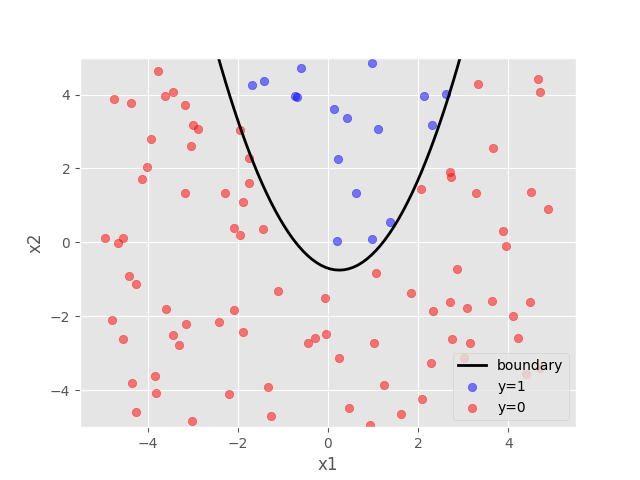

In [14]:
# Scatter plot for the quadratic boundary
num_samples = 100
# Interactive scatter plot:
with plt.ioff():
    fig = plt.figure()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
np.random.seed(42)  # For reproducibility
x1s = np.random.uniform(-5, 5, num_samples)
x2s = np.random.uniform(-5, 5, num_samples)
y_true = np.where(x2s > a.value * x1s**2 + b.value * x1s + c.value, 1, 0)
positive_x1s = x1s[y_true == 1]
positive_x2s = x2s[y_true == 1]
negative_x1s = x1s[y_true == 0]
negative_x2s = x2s[y_true == 0]
ax = plt.gca()
ax.plot(np.linspace(-5, 5, 100), a.value * np.linspace(-5, 5, 100) ** 2 + b.value * np.linspace(-5, 5, 100) + c.value, color='black', lw=2.0, label='boundary')
ax.scatter(positive_x1s, positive_x2s, color='blue', label='y=1', alpha=0.5)
ax.scatter(negative_x1s, negative_x2s, color='red', label='y=0', alpha=0.5)
ax.legend()
ax.set_ylim(-5, 5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
display(fig.canvas)

## Hidden neurons
Hidden neurons allow for non-linear boundaries (the more hidden layers, the more 'non-linearity' in general).

For this to be true, we need to choose a non-linear 'activation' function on the hidden layers. In practice, ReLU is commonly used (implemented below).

The motivation of the ReLU is that it 'mimics' neurons in the brain that 'turns off' (becomes zero) when the input is below a predefined threshold of 0.

Since we don't know how many hidden neurons we need, let's just use a lot, say 10 hidden neurons (and a hidden bias), then we can model the neural network as follows (using PyTorch for convenience).

Now, we won't bother calculating values manually as there are a lot of weight parameters, but to calculate the output, we would just start from the inputs on the left and follow the arrows to the output neuron.

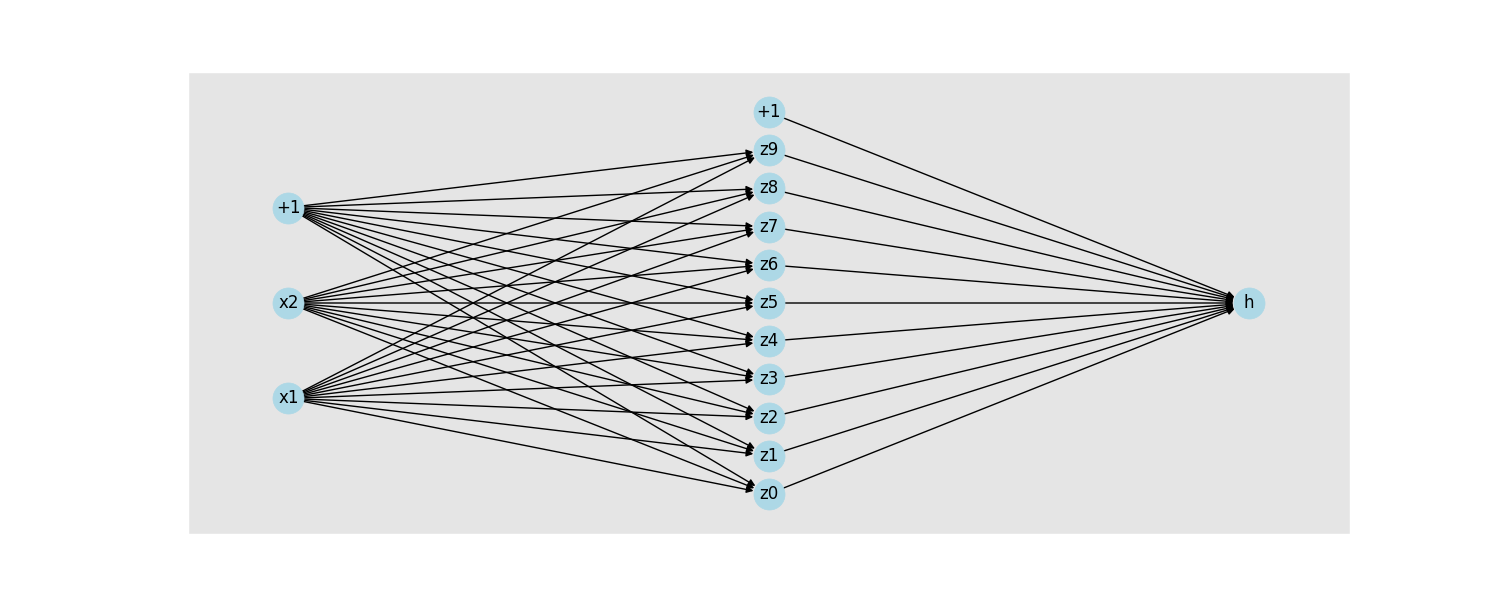

In [ ]:
# Use pytorch to implement the neural network, and use binary cross entropy loss function.
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

# Visualize the neural network using networkx
input_nodes = ['x1', 'x2', 'bias_0']
hidden_nodes = [f'z{i}' for i in range(10)] + ['bias_h']
output_nodes = ['h']

net = nx.DiGraph()
ys = np.linspace(150, 350, len(input_nodes))
for i, node in enumerate(input_nodes):
    net.add_node(node, pos=(0, ys[i]), label=node)
net.nodes['bias_0']['label'] = '+1'

ys = np.linspace(50, 450, len(hidden_nodes))
for i, node in enumerate(hidden_nodes):
    net.add_node(node, pos=(50, ys[i]), label=node)
    if node != 'bias_h':
        for input_node in input_nodes:
            net.add_edge(input_node, node, title=f'w_{input_node}_{node}')
net.nodes['bias_h']['label'] = '+1'

net.add_node('h', pos=(100, 250), label='h')
for hidden_node in hidden_nodes:
    net.add_edge(hidden_node, 'h', title=f'w_{hidden_node}_h')

fig = plt.figure(figsize=(15, 6))
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
plt.grid(False)
nx.draw_networkx(net,
                 pos=nx.get_node_attributes(net, 'pos'), 
                 with_labels=False,
                 node_size=500, 
                 node_color='lightblue', 
                 font_size=10, 
                 font_color='black', 
                 arrows=True)
nx.draw_networkx_labels(net, pos=nx.get_node_attributes(net, 'pos'),
                        labels=nx.get_node_attributes(net, 'label'),
                        font_size=12, 
                        font_color='black')
plt.show()

# Random weights - Boundaries

(Re)run the cell below to randomly (re)initialize model weights along the edges of the network and plot the decision boundary.

Run multiple times to see funky (highly non-linear) boundaries!

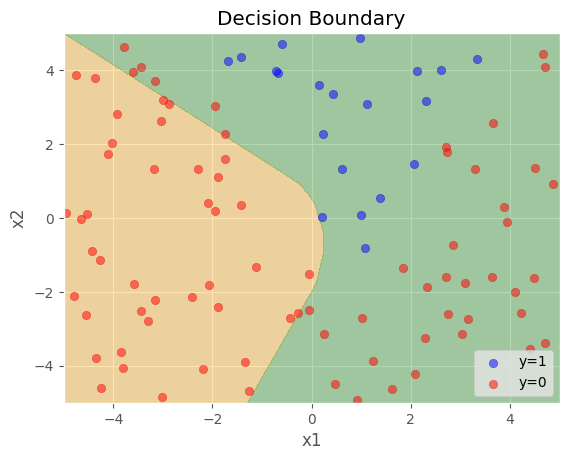

In [ ]:
neural_net = SimpleNN(input_size=2, hidden_size=10, output_size=1)

with plt.ioff():
    fig = plt.figure()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    ax = plt.gca()
    
def plot_decision_boundary(ax, neural_net):
    # Create a grid of points
    x1_grid = np.linspace(-5, 5, 100)
    x2_grid = np.linspace(-5, 5, 100)

    # For each pair of (x1, x2), compute the output of the neural network
    x1_mesh, x2_mesh = np.meshgrid(x1_grid, x2_grid)
    grid_points = np.column_stack((x1_mesh.ravel(), x2_mesh.ravel()))

    # Convert to torch tensor
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

    # Forward pass through the neural network
    with torch.no_grad():
        outputs = neural_net(grid_tensor)
        outputs = torch.sigmoid(outputs).numpy().reshape(x1_mesh.shape)

    # Plot the decision boundary
    c = ax.contourf(x1_mesh, x2_mesh, outputs, levels=[0, 0.5, 1], colors=['orange', 'green'], alpha=0.3)
    ax.scatter(positive_x1s, positive_x2s, color='blue', label='y=1', alpha=0.5)
    ax.scatter(negative_x1s, negative_x2s, color='red', label='y=0', alpha=0.5)
    ax.legend()
    ax.set_title('Decision Boundary')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')

initial_state = deepcopy(neural_net.state_dict())

plot_decision_boundary(ax, neural_net)
display(fig)

# Learning Algorithm (again)
Again, let's visualize the decision boundary at each update of the "learning" (gradient descent) algorithm and see how well it does as the algorithm runs.

The parameters are initialized in the cell above (so the initial boundary will be as above).

In [ ]:
# Initialize the model history to store the model state at each epoch
model_history = [deepcopy(initial_state)]
neural_net = SimpleNN(input_size=2, hidden_size=10, output_size=1)
neural_net.load_state_dict(initial_state)

# Again, let's train with binary cross entropy loss function and record the decision boundary at each epoch
num_epochs = 100
learning_rate = 0.5
criterion = nn.BCEWithLogitsLoss() # Same as binary cross entropy loss function above, but using Pytorch logits (the output of last layer)
optimizer = optim.SGD(neural_net.parameters(), lr=learning_rate)

# Prepare the training dataset
x_tensor = torch.tensor(np.column_stack((x1s, x2s)), dtype=torch.float32)
y_tensor = torch.tensor(y_true, dtype=torch.float32).view(-1, 1)  # Reshape to match output shape

# Training loop
for epoch in range(num_epochs):
    outputs = neural_net(x_tensor) # Forward pass
    loss = criterion(outputs, y_tensor) # Compute the loss
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    optimizer.zero_grad() # Reset gradients for the next iteration
    
    model_history.append( deepcopy( neural_net.state_dict() ) ) # Store the model state at each epoch

iteration_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(model_history)-1,
    step=1,
    description='Epoch/Iteration'
)

iteration_slider.layout.width = '50%'

with plt.ioff():
    fig = plt.figure()
    fig.canvas.toolbar_visible = False
    fig.canvas.header_visible = False
    ax = plt.gca()

def plot_decision_boundary_epoch(epoch):
    ax = plt.gca()
    ax.clear()
    neural_net.load_state_dict(model_history[epoch])
    plot_decision_boundary(ax, neural_net)

def update_epoch(change):
    epoch = change['new']
    plot_decision_boundary_epoch(epoch)
    fig.canvas.draw()
    fig.canvas.flush_events()

iteration_slider.observe(update_epoch, names='value')

model_boundary_app = AppLayout(
    header=None,
    left_sidebar=None,
    center=fig.canvas,
    pane_height = [1, 6, 1],
    footer = iteration_slider
)
plot_decision_boundary_epoch(0)  # Initial plot
display(model_boundary_app)

AppLayout(children=(IntSlider(value=0, description='Epoch/Iteration', layout=Layout(grid_area='footer', width=…